In [1]:
import pandas as pd
import joblib
from pandas import datetime
import numpy as np
import matplotlib.pyplot as plt
from flaml import AutoML
import statsmodels.api as sm
%matplotlib inline 
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

/var/folders/xs/_lq9tnfn6p76h6lv7zwx1czr0000gn/T/ipykernel_9034/4119604105.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
/Users/wenqingan/mambaforge/envs/keras/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/wenqingan/mambaforge/envs/keras/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
multi_df = pd.read_csv(
    "https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv"
)

# preprocessing data
multi_df["timeStamp"] = pd.to_datetime(multi_df["timeStamp"])
multi_df = multi_df.set_index("timeStamp")
multi_df = multi_df.resample("D").mean()
multi_df["temp"] = multi_df["temp"].fillna(method="ffill")
multi_df["precip"] = multi_df["precip"].fillna(method="ffill")
multi_df = multi_df[:-2]  # last two rows are NaN for 'demand' column so remove them
multi_df = multi_df.reset_index()

# Using temperature values create categorical values
# where 1 denotes daily tempurature is above monthly average and 0 is below.
def get_monthly_avg(data):
    data["month"] = data["timeStamp"].dt.month
    data = data[["month", "temp"]].groupby("month")
    data = data.agg({"temp": "mean"})
    return data

monthly_avg = get_monthly_avg(multi_df).to_dict().get("temp")

def above_monthly_avg(date, temp):
    month = date.month
    if temp > monthly_avg.get(month):
        return 1
    else:
        return 0

multi_df["temp_above_monthly_avg"] = multi_df.apply(
    lambda x: above_monthly_avg(x["timeStamp"], x["temp"]), axis=1
)

del multi_df["month"]  # remove temperature column to reduce redundancy

# split data into train and test
num_samples = multi_df.shape[0]
multi_time_horizon = 180
split_idx = num_samples - multi_time_horizon
multi_train_df = multi_df[:split_idx]
multi_test_df = multi_df[split_idx:]

multi_X_test = multi_test_df[
    ["timeStamp", "precip", "temp", "temp_above_monthly_avg"]
]  # test dataframe must contain values for the regressors / multivariate variables
multi_y_test = multi_test_df["demand"]

# initialize AutoML instance
automl = AutoML()

# configure AutoML settings
settings = {
    "time_budget": 30,  # total running time in seconds
    "metric": "auto",  # primary metric
    "task": "ts_forecast",  # task type
    "log_file_name": "energy_forecast_categorical.log",  # flaml log file
    "eval_method": "cv",
    "log_type": "all",
    "label": "demand",
}

# train the model
automl.fit(dataframe=multi_train_df, **settings, period=multi_time_horizon)

[flaml.automl: 09-28 15:41:20] {2600} INFO - task = ts_forecast
[flaml.automl: 09-28 15:41:20] {2602} INFO - Data split method: time
[flaml.automl: 09-28 15:41:20] {2605} INFO - Evaluation method: cv
[flaml.automl: 09-28 15:41:20] {2727} INFO - Minimizing error metric: mape
[flaml.automl: 09-28 15:41:20] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'arima', 'sarimax']
[flaml.automl: 09-28 15:41:20] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 09-28 15:41:20] {3307} INFO - Estimated sufficient time budget=893s. Estimated necessary time budget=1s.
[flaml.automl: 09-28 15:41:20] {3354} INFO -  at 0.1s,	estimator lgbm's best error=0.0928,	best estimator lgbm's best error=0.0928
[flaml.automl: 09-28 15:41:20] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 09-28 15:41:20] {3354} INFO -  at 0.2s,	estimator lgbm's best error=0.0928,	best estimator lgbm's best error=0.0928
[flaml.automl: 09-28 15:41:

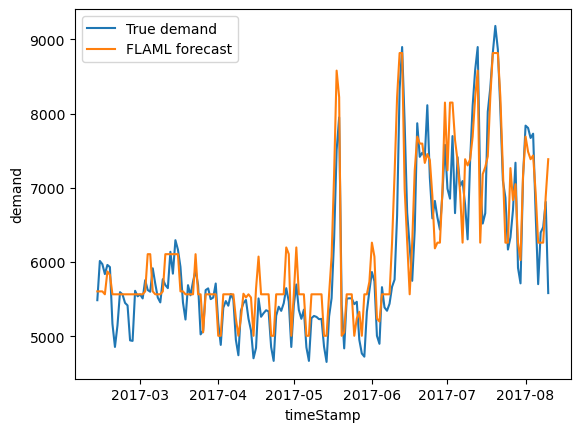

In [3]:
flaml_y_pred = automl.predict(multi_X_test)

plt.plot(multi_X_test['timeStamp'], multi_y_test, label='True demand')
plt.plot(multi_X_test['timeStamp'], flaml_y_pred, label='FLAML forecast')
plt.xlabel('timeStamp')
plt.ylabel('demand')
plt.legend()

In [4]:
joblib.dump(automl, "FLAML_MultiTime.sav")

['FLAML_MultiTime.sav']